# Using LLMs for PII Masking

#### Author: Abdul Jilani

## Loading Libraries

In [1]:
import datasets
import re
import pandas as pd
from fuzzywuzzy import fuzz
import openai
from pydantic import BaseModel, Field
from openai import OpenAI
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
os.environ["OPENAI_API_KEY"] = ""

## Initializing OpenAI API

In [3]:
assert os.environ.get("OPENAI_API_KEY") is not None
client = OpenAI()

## OpenAI Function Calling

This is necessary to implement normalization of the output and reduce the amount of post-processing of the response from the LLM. 

In [4]:
def redact_pii(text):
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "You are an AI assistant, skilled in masking \
         personally identifiable information including names or other information related to persons, organizations\
         in text blocks and returning them as a python json object.\
         Do not return as a code block."},
        {"role": "user", "content": "Mask all PII data in the following text with [REDACTED] token. \
        \ Use the following structure: {\"masked_text\": } \n \n '''" + text + "'''"}
      ],
      seed = 42
    )
    return completion.choices[0]

In [5]:
class RedactTextParams(BaseModel):
    redacted_text: str = Field(description="Returned text after masking all PII data with [REDACTED] token")
        
tool_definitions = [  
    {
        "type": "function",
        "function":{
            "name": "redact_pii_from_text",
            "description": "Generates masked text after removing all PII information related to persons \
             and companies to be uploaded into the datalake",
            "parameters": RedactTextParams.model_json_schema()
        },
        "required": ["redacted_text"]
    }
]

In [13]:
def redact_pii_fc(text):
    completion = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {"role": "system", "content": "You are an AI assistant, skilled in masking \
        personally identifiable information including incompleted names or other information \
        related to persons, organizations, including hash keys, crypto addresses, API keys \
        in text blocks. Do not return as a code block. Mask all PII related words in the following \
        text with [REDACTED] token.'''" + text + "'''"}
      ],
      seed = 42,
      tools=tool_definitions,
      tool_choice={"type": "function", "function": {"name": "redact_pii_from_text"}}
    )
    response = json.loads(completion.choices[0].message.tool_calls[0].function.arguments)
    return [val for val in response.values()][0]

## PII Dataset
We will be using Huggingface's PII dataset [ai4privacy/pii-masking-65k](https://huggingface.co/datasets/ai4privacy/pii-masking-65k) for this demo. This dataset is provided by [AI4Privacy](https://ai4privacy.com/) and contains data that can be used for training and validating PII masking models.  

In [7]:
dataset_name = 'ai4privacy/pii-masking-65k'
dataset = datasets.load_dataset(dataset_name, split="train[:10%]")
dataset

Dataset({
    features: ['masked_text', 'unmasked_text', 'token_entity_labels', 'tokenised_unmasked_text'],
    num_rows: 2159
})

In [8]:
df_dataset = dataset.to_pandas()
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159 entries, 0 to 2158
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   masked_text              2159 non-null   object
 1   unmasked_text            2159 non-null   object
 2   token_entity_labels      2159 non-null   object
 3   tokenised_unmasked_text  2159 non-null   object
dtypes: object(4)
memory usage: 67.6+ KB


## Running LLM Masking on sample data

We will run the LLM Masking on a sample of the dataset and compare the results with actual masking expected.

In [14]:
df_dataset_sample = df_dataset.sample(100)
results = []
for i, row in tqdm(df_dataset_sample.iterrows()):
    #print(i)
    masked_text = redact_pii_fc(row['unmasked_text'])
    actual_cleansed = re.sub(r'\[.*?\]', '', row['masked_text'])
    llm_cleansed = masked_text.replace('[REDACTED]','')                        
    results.append([actual_cleansed,llm_cleansed,row['masked_text'], masked_text, fuzz.ratio(actual_cleansed, llm_cleansed)])

100it [01:52,  1.12s/it]


In [15]:
assert len(results)==100

In [16]:
df_results = pd.DataFrame(results, columns = ['actual_cleansed','llm_cleansed', 
                                              'actual_masked','llm_masked', 'match_score'])
df_results[['actual_masked','llm_masked','match_score']].sample(10)

,actual_masked,llm_masked,match_score
39,"[MIDDLENAME_1], we need to finalize our terms ...","Alex, we need to finalize our terms of service...",92
27,For the merger between [COMPANY_NAME_1] and [C...,For the merger between Jakubowski - Denesik an...,89
33,"Dear [PREFIX_1], we would like to send some th...","Dear Dr., we would like to send some therapy m...",95
72,Please schedule an appointment for Therapy ses...,Please schedule an appointment for Therapy ses...,75
65,"Following the Securities Law, I kindly request...","Following the Securities Law, I kindly request...",88
54,For [SEX_1] employee's health insurance polici...,"For male employee's health insurance policies,...",99
12,"As our [JOBTYPE_1] in psychoeducation, we woul...","As our Analyst in psychoeducation, we would ap...",94
79,"Dear [SEX_1], As a leading figure in adolescen...","Dear female, As a leading figure in adolescent...",97
34,"""We have assigned an encrypted password [PASSW...",We have assigned an encrypted password [REDACT...,99
57,"Hi, I'd like to make an online payment for my ...","Hi, I'd like to make an online payment for my ...",92


## Results
As evident that the LLM is able to match the expected result of masking and can be improved further with better prompting strategies. From a time perspective, it took an llm roughly 1 second to mask a sentence and produce the masked output which would have taken significantly longer for a human to do manually.

(0.0, 100.0)

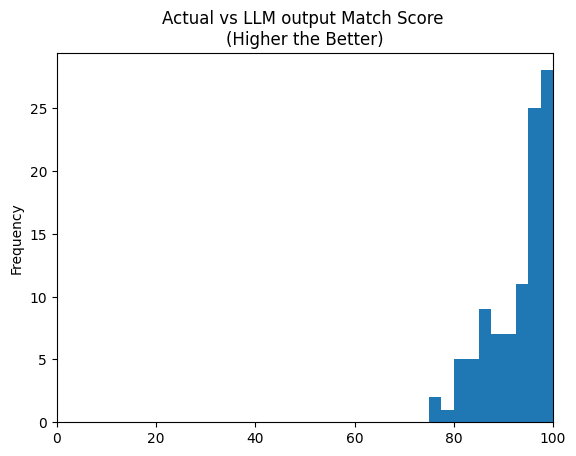

In [17]:
df_results.match_score.plot.hist(title='Actual vs LLM output Match Score \n(Higher the Better)')
plt.xlim(0,100)

## Conclusion
LLMs provide an efficient way of PII masking without the need for training new models and retraining over time. They help reducing the manual effort in masking the data and can also be used as moderators to identify and intervene content which contains PII information. 

It is recommended to use Local LLMs and SLMs for PII masking to avoid leaking data to external providers. Connect with us to talk about our product [Guardgen](https://guardgen.ai/) which can help you in securely masking PII data with LLMs with in your infrastructure.
